In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize
from dask_ml.wrappers import Incremental

from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve
import time, re, os, sys

from scipy.sparse import csr_matrix
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [2]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

enroll_spk.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
id,,,,,,,,,,,,,,,,,,,,,
4780420411,0.014026,0.054789,0.025725,0.016863,0.063301,0.114704,0.070258,0.000567,0.045729,0.044964,...,0.077940,0.032820,0.022656,0.028034,0.035296,0.046987,0.036155,0.016219,0.011507,0.070774
4779876202,0.030303,0.022931,0.033079,0.058957,0.079296,0.049778,0.068490,0.003525,0.072742,0.030553,...,0.061358,0.044687,0.020264,0.007364,0.051940,0.062175,0.052892,0.026529,0.014570,0.025142
4778192381,0.055344,0.035090,0.026809,0.068782,0.045188,0.081985,0.033221,0.012631,0.026813,0.046449,...,0.075565,0.056208,0.029324,0.006928,0.055884,0.062326,0.022718,0.040709,0.015717,0.102008
4780265567,0.012624,0.058721,0.033892,0.054483,0.041132,0.115025,0.074992,0.000893,0.087311,0.076028,...,0.068856,0.051828,0.054921,0.011270,0.066159,0.043747,0.031619,0.033663,0.032096,0.073277
4777987958,0.054659,0.054360,0.014665,0.050420,0.064626,0.115716,0.107942,0.008013,0.069778,0.092527,...,0.102160,0.041830,0.015103,0.031850,0.061312,0.079773,0.071351,0.070432,0.031396,0.099793


In [5]:
# For tests

spkr = enroll_spk_raw.loc[4780420411]
test = test_spk_raw.loc['fc_4779547143_0']

In [ ]:
from DataFunctions import calcEER

In [6]:
def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

In [7]:
def cos_with_variance(dist1, vect2):
    m = dist1.mean(axis=0)
    cos = 1 - cosine(m, vect2)
    v = dist1.var(axis=0)
    return np.concatenate([np.array([cos]), v])

# Load data 

In [8]:
X_cos, Y_cos = run_test(cos_similarity, 0.01, True, enroll_spk, test_spk, n_features=1)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


In [21]:
X_cos_tenth, Y_cos_tenth = run_test(cos_similarity, 0.1, True, enroll_spk, test_spk, n_features=1)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


# 1a. Cos/Variance with RF

In [21]:
X, Y = run_test(cos_with_variance, 0.01)
X_csr = csr_matrix(np.vstack(X.values))
rf = RandomForestClassifier(verbose = 1, n_jobs=8)
rf.fit(X_csr, Y)

[########################################] | 100% Completed | 35.3s
[########################################] | 100% Completed | 35.4s
[########################################] | 100% Completed | 35.4s
[########################################] | 100% Completed | 35.5s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.6s


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    5.0s remaining:    3.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    7.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [12]:
rf_cos = RandomForestClassifier(verbose = 1, n_jobs=8)
X_cos_a = np.array(X_cos).reshape((-1,1))
rf_cos.fit(X_cos_a, Y_cos)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

# 1b. Cos/Variance with PAC (incremental learning)
We try to see if PAC performs as well as RF so that we can work with larger datasets. 
I don't believe there is a workaround using large data with sklearn on limited memory besides using online learning to learn on data sequentially. 

http://scikit-learn.org/stable/modules/scaling_strategies.html

http://dask-ml.readthedocs.io/en/latest/incremental.html - addresses this exact problem

In [17]:
from sklearn.neural_network import MLPClassifier

In [19]:
nn = Incremental(MLPClassifier(random_state=1, verbose=True))

In [20]:
nn.fit(X_cos, Y_cos, classes=[0,1])

/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not em

Iteration 1, loss = 0.85373559
Iteration 2, loss = 0.80209452
Iteration 3, loss = 0.75273747
Iteration 4, loss = 0.70617010
Iteration 5, loss = 0.66205026
Iteration 6, loss = 0.62092906
Iteration 7, loss = 0.58306952
Iteration 8, loss = 0.54634894
Iteration 9, loss = 0.51084818
Iteration 10, loss = 0.47929058
Iteration 11, loss = 0.44553839
Iteration 12, loss = 0.41523888
Iteration 13, loss = 0.38785631
Iteration 14, loss = 0.36061563
Iteration 15, loss = 0.33401985
Iteration 16, loss = 0.31056922
Iteration 17, loss = 0.28585256
Iteration 18, loss = 0.26814792
Iteration 19, loss = 0.24712180
Iteration 20, loss = 0.22610379
Iteration 21, loss = 0.21195280
Iteration 22, loss = 0.19774158
Iteration 23, loss = 0.18011730
Iteration 24, loss = 0.16867914
Iteration 25, loss = 0.15455025
Iteration 26, loss = 0.14351748
Iteration 27, loss = 0.13334258
Iteration 28, loss = 0.12613541
Iteration 29, loss = 0.11326864
Iteration 30, loss = 0.11202583
Iteration 31, loss = 0.10749686
Iteration 32, los

/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not em

/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not em

Iteration 69, loss = 0.01599366
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 70, loss = 0.02475803
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 71, loss = 0.02441286
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 72, loss = 0.00990752
Iteration 73, loss = 0.01420483
Iteration 74, loss = 0.00896606
Iteration 75, loss = 0.01336830
Iteration 76, loss = 0.02287803
Iteration 77, loss = 0.01771259
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 78, loss = 0.00742751
Iteration 79, loss = 0.02740675
Iteration 80, loss = 0.02213877
Iteration 81, loss = 0.01685434
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 82, loss = 0.00633713
Iteration 83, loss = 0.01126431
Iteration 84, loss = 0.01113292
Iteration 85, loss = 0.02148984
T

/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not em

Iteration 109, loss = 0.03346157
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 110, loss = 0.00879612
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 111, loss = 0.02100397
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 112, loss = 0.01494667
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 113, loss = 0.01494372
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 114, loss = 0.00253206
Iteration 115, loss = 0.01489807
Iteration 116, loss = 0.00861475
Iteration 117, loss = 0.02750289
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 118, loss = 0.02750072
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if np.setdiff1d(classes, self.classes_, assume_unique=True):
/work4/kenneth/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:927: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not em

Incremental(MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False))

In [22]:
nn_cos_tenth_prob = nn.predict_proba(X_cos_tenth)

In [25]:
p = ProgressBar()
p.register()
res = nn_cos_tenth_prob[:,1].compute()
p.unregister()

[########################################] | 100% Completed |  6min  4.6s


In [28]:
Y_cos_tenth.compute()

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
1-res

array([0.99754769, 0.99743965, 0.99728786, ..., 0.99761713, 0.99757408,
       0.99745455])

Threshold:  0.9977736497541141
EER:  0.08507121655384484


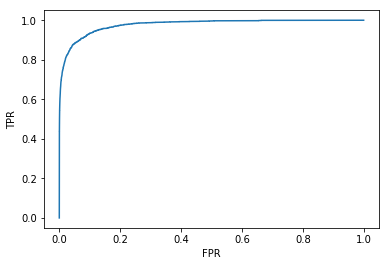

In [33]:
calcEER(1-res, Y_cos_tenth.compute())

In [38]:
def calcEER_print(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    print(fpr)
    print(tpr)
    print(thresholds)
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER: ", fpr[minPt])
    
    return